<a href="https://colab.research.google.com/github/noamiel/AdvancedProgrammingWebApp/blob/main/ImageProcessingProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import h5py
from matplotlib import *
import sys
import pylab as pl
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torch.autograd import Variable
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# sudo pip install h5py

In [ ]:
!pip install omnipose
import omnipose

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 3.0 MB/s 
     |████████████████████████████████| 168 kB 24.6 MB/s 
     |████████████████████████████████| 2.8 MB 63.9 MB/s 
     |████████████████████████████████| 3.5 MB 38.3 MB/s 
     |████████████████████████████████| 47.8 MB 1.3 MB/s 
     |████████████████████████████████| 31.0 MB 1.4 MB/s 
     |████████████████████████████████| 3.3 MB 35.9 MB/s 
     |████████████████████████████████| 34.5 MB 10 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


ImportError: ignored

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:

from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My Drive/Colab Notebooks/project


In [ ]:
def plotSamplesOneHots(labels_of_samples, output_file=False):
    '''
    labels_of_samples of shape (num_samples, x, y, num_onehots)
    '''
    if len(labels_of_samples.shape) != 4:
        print("Incorrect input size - should be (num_samples, x, y, num_onehots)")
    num_samples = labels_of_samples.shape[0]
    num_onehots = labels_of_samples.shape[1]
    figure_size = (4*num_onehots, 4*num_samples)
    fig, ax = plt.subplots(num_samples, num_onehots, sharex=True, sharey=True, figsize=figure_size)
    for i in range(num_samples):
        for j in range(num_onehots):
            ax[i, j].imshow(labels_of_samples[i,j,...], aspect="auto")
    fig.tight_layout()
    plt.show()
    if output_file == True:
        fig.savefig(output_file)
        
def makeXbyY(data, X, Y):
    '''
    Crop data to size X by Y
    '''
    if len(data.shape) < 3:
        print('Input should be of size (num_samples, x, y,...)')
    data_x_start = int((data.shape[1]-X)/2)
    data_y_start = int((data.shape[1]-Y)/2)
    arrayXbyY = data[:, (data_x_start):(data_x_start + X), (data_y_start):(data_y_start + Y),...]
    return arrayXbyY

def findNearestNeighbourLabel(array):
    center = int(array.shape[0]/2)
    labels_count = np.zeros(5)
    for x in range(array.shape[0]):
        for y in range(array.shape[1]):
            if (x != center) or (y != center):
                temp_label = array[x, y]
                labels_count[temp_label] += 1
    return labels_count.argmax()

def cleanLabelNearestNeighbour(label,num_of_classes):
    '''
    Corrects incorrect labels in a single image based on a threshold on the number of 
    nearest neighbours with the same label
    '''
    x_length = label.shape[0]
    y_length = label.shape[1]
    # num_of_classes = 4
    cleaned_labels = np.zeros((x_length, y_length, 4))
    for x in range(1,x_length-1):
        for y in range(1, y_length-1):
            temp_label = label[x,y]
            if temp_label >3: # if labeled as 4 or above
                temp_label = findNearestNeighbourLabel(label[(x-1):(x+2), (y-1):(y+2)])
                cleaned_labels[x, y, temp_label] = 1
            elif temp_label > 0:
                num_labels_in_3x3 = len(np.where(label[(x-1):(x+2), (y-1):(y+2)]==temp_label)[0])
                if num_labels_in_3x3 > 3:
                    cleaned_labels[x, y, temp_label] = 1
                else:
                    temp_label = findNearestNeighbourLabel(label[(x-1):(x+2), (y-1):(y+2)])
                    cleaned_labels[x, y, temp_label] = 1
        non_zero_array = cleaned_labels[..., 1:].sum(axis=2).astype('bool')
        cleaned_labels[..., 0] = np.ones((x_length, y_length), dtype='bool')^non_zero_array
    return cleaned_labels

def cleanLabelNearestNeighbour_alllabels(labels):    
    '''
    Cleans incorrect labels
    '''
    num_labels = labels.shape[0] # count of data set
    num_of_classes = 4
    cleaned_dim = list(labels.shape) #[13434, 94, 93]
    cleaned_dim.append(num_of_classes) # [13434, 94, 93,4]
    cleaned_labels = np.zeros(cleaned_dim)
    for image_i in range(num_labels):
        # print('Preprocessing image %d of %d' % (image_i, num_labels))
        cleaned_labels[image_i,...] = cleanLabelNearestNeighbour(labels[image_i, ...],num_of_classes)
    return cleaned_labels

def meanIOU_per_image(y_pred, y_true):
    '''
    Calculate the IOU, averaged across images
    '''
    if len(y_pred.shape) < 3 or (y_pred.shape[2]<4):
        print('Wrong dimensions: one hot encoding expected')
        return
    y_pred = y_pred.astype('bool')
    y_true = y_true.astype('bool')
    IUs = []
    for layer in range(y_true.shape[1]):
        intersection = y_pred[:,layer,...] & y_true[:,layer,...]
        union = y_pred[:,layer,...] | y_true[:,layer,...]
        if union.sum() == 0:
            IUs.append(1)
        else:
            IUs.append(intersection.sum()/union.sum())
    return sum(IUs)/len(IUs)

def meanIOU(y_pred, y_true):
    '''
    Calculate the mean IOU, with the mean taken over classes
    '''
    if len(y_pred.shape) < 4 or (y_pred.shape[1]<4):
        print('Wrong dimensions: one hot encoding expected')
        return
    y_pred = y_pred.astype('bool')
    y_true = y_true.astype('bool')
    IUs = []
    for layer in range(y_true.shape[1]):
        intersection = y_pred[:,layer,...] & y_true[:,layer,...]
        union = y_pred[:,layer,...] | y_true[:,layer,...]
        if union.sum() == 0:
            IUs.append(1)
        else:
            IUs.append(intersection.sum()/union.sum())
    return sum(IUs)/len(IUs)
	
def IOU(y_pred, y_true):
    '''
    Calculate the IOU for each class seperately
    '''
    if len(y_pred.shape) < 4 or (y_pred.shape[1]<4):
        print('Wrong dimensions: one hot encoding expected')
        return
    y_pred = y_pred.astype('bool')
    y_true = y_true.astype('bool')
    #print(y_pred)
    #print(y_true)
    IUs = []
    for layer in range(y_true.shape[1]):
        intersection = y_pred[:,layer,...] & y_true[:,layer,...]
        union = y_pred[:,layer,...] | y_true[:,layer,...]
        #print(intersection.sum(), union.sum())
        if union.sum() == 0:
            IUs.append(1)
        else:
            IUs.append(intersection.sum()/union.sum())
    return IUs

# One-hot encoding
def oneHotEncode(initial_array):
    '''
    One hot encode the labels
    '''
    allowed_max_class_num = 3
    output_shape = list(initial_array.shape)
    output_shape[-1] = initial_array.max()
    output_array_dims = list(initial_array.shape)
    output_array_dims.append(4)
    output_array = np.zeros(output_array_dims)
    for image_i in range(0, initial_array.shape[0]):
        for class_num in range(0, allowed_max_class_num):
            for x in range(0, initial_array.shape[1]):
                for y in range(0, initial_array.shape[2]):
                    if initial_array[image_i, x, y] == class_num:
                        output_array[image_i, x, y, class_num] = 1

        class_num = allowed_max_class_num
        for x in range(0, initial_array.shape[1]):
            for y in range(0, initial_array.shape[2]):
                if initial_array[image_i, x, y] >= allowed_max_class_num:
                    output_array[image_i, x, y, class_num] = 1
    return output_array

# Global Accuracy
def globalAccuracy(y_pred, y_true):
    # Calculate the global accuracy (ie. percent of pixels correctly labelled)
    
    y_pred = y_pred.astype('bool')
    y_true = y_true.astype('bool')

    correct = y_pred & y_true
    num_correct = correct.sum()
    num_total = 1
    shape_dim=list(y_true.shape)
    shape_dim.remove(4)
    shape_dim
    for dim in shape_dim:
        # print(dim)
        num_total = num_total*dim
    return num_correct/num_total

In [ ]:
!wget 'https://github.com/jeanpat/DeepFISH/raw/master/dataset/LowRes_13434_overlapping_pairs.h5'
!mv 'LowRes_13434_overlapping_pairs.h5' dataset/

file_path = 'dataset/LowRes_13434_overlapping_pairs.h5'
h5f = h5py.File(file_path,'r')
xdata = h5f['dataset_1'][...,0]
labels = h5f['dataset_1'][...,1]
h5f.close()
print(f'Shape of Images: {xdata.shape} \nShape of Labels: {labels.shape}')

In [ ]:
# First overlapped chromosome image
# This is grayscale image with shape (94, 93)
xdata[0].shape

# It is observed that some intensities of pixels are negative. I am not able to figure out why?
np.unique(xdata[0])

# Though negative intensities quantity is not much.

unique, counts = np.unique(xdata[0], return_counts=True)
print(np.asarray((unique, counts)).T)

# Image

fig = pl.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(xdata[0], aspect="auto")

# Label of the first overlapped chromosome image
# Lets see the unique intensity values of pixels
#np.unique(labels[0])
unique, counts = np.unique(labels[0], return_counts=True)
print(np.asarray((unique, counts)).T)

# This clearly indicates the masks for the four classes
# Image:
fig = pl.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(labels[0], aspect="auto")

# But we can observe that there are different coulors at the boundaries. So cleaning is requried.

# Clean the Labels
labels_cleaned = cleanLabelNearestNeighbour_alllabels(labels)
print(f'Shape of Images: {xdata.shape} \nShape of Labels: {labels_cleaned.shape}')

# Reshape image to height = width = 88
xdata_equal = makeXbyY(xdata, 88, 88)
labels_equal = makeXbyY(labels_cleaned, 88, 88)

print(f'Shape of Images: {xdata_equal.shape} \nShape of Labels: {labels_equal.shape}')

# Reshape Data and Labels
# Add one 1 empty channel for gray scale Images (13434, 88, 88) to (13434, 1, 88, 88)
# Reshape labels from (13434, 88, 88, 4) to (13434, 4, 88, 88)
xdata1 = np.expand_dims(xdata_equal, axis=1)
labels1 = np.transpose(labels_equal, (0, 3, 1, 2))
print(f'Shape of Images: {xdata1.shape} \nShape of Labels: {labels1.shape}')

# Lets see first two images and its final labels
fig = pl.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(xdata1[0][0], aspect="auto")

fig = pl.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(xdata1[1][0], aspect="auto")

plotSamplesOneHots(labels1[0:2])

# Save the procossed data
np.save('dataset/xdata_88x88', xdata1)
np.save('dataset/ydata_88x88_0123_onehot', labels1)

Shape of Images: (13434, 1, 88, 88) 
Shape of Labels: (13434, 4, 88, 88)
torch.Size([1, 1, 88, 88])
torch.Size([1, 4, 88, 88])


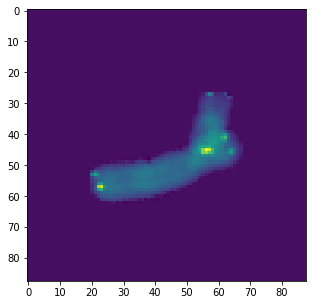

In [ ]:
# Load the processed data
xdata_loaded = np.load('dataset/xdata_88x88.npy')
labels_loaded = np.load('dataset/ydata_88x88_0123_onehot.npy')

print(f'Shape of Images: {xdata_loaded.shape} \nShape of Labels: {labels_loaded.shape}')

# Dataset Conversion in Pytorch format

class ChromosomeDataset(Dataset):
  def __init__(self, xdata_loaded, labels_loaded, transform=None):
    super().__init__()
    self.transform = transform
        
  def __len__(self):
    return xdata_loaded.shape[0]
    
  def __getitem__(self, idx):
    return xdata_loaded[idx], labels_loaded[idx]

batch_size = 1
dataset = ChromosomeDataset(xdata_loaded, labels_loaded)
train_ds, test_ds = torch.utils.data.random_split(dataset, (12434, 1000)) # train on 12434 and tested on 1000
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

xb, yb = next(iter(train_dataloader))
print(xb.shape)
print(yb.shape)

fig = pl.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(xb.cpu().detach().numpy()[0][0], aspect="auto")

In [ ]:
!rm unet.py
!wget https://raw.githubusercontent.com/jvanvugt/pytorch-unet/master/unet.py

from unet import UNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_classes=4, depth=4, padding=True, up_mode='upsample').to(device)
optim = torch.optim.Adam(model.parameters())

!pip install torchinfo
from torchinfo import summary
summary(model, input_size=(1,1, 88, 88))

--2022-06-02 08:17:29--  https://raw.githubusercontent.com/jvanvugt/pytorch-unet/master/unet.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4320 (4.2K) [text/plain]
Saving to: ‘unet.py’

unet.py             100%[===================>]   4.22K  --.-KB/s    in 0.003s  

2022-06-02 08:17:30 (1.37 MB/s) - ‘unet.py’ saved [4320/4320]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 4, 88, 88]            --
├─ModuleList: 1-1                        --                        --
│    └─UNetConvBlock: 2-1                [1, 64, 88, 88]           --
│    │    └─Sequential: 3-1              [1, 64, 88, 88]           37,568
│    └─UNetConvBlock: 2-2                [1, 128, 44, 44]          --
│    │    └─Sequential: 3-2              [1, 128, 44, 44]          221,440
│    └─UNetConvBlock: 2-3                [1, 256, 22, 22]          --
│    │    └─Sequential: 3-3              [1, 256, 22, 22]          885,248
│    └─UNetConvBlock: 2-4                [1, 512, 11, 11]          --
│    │    └─Sequential: 3-4              [1, 512, 11, 11]          3,539,968
├─ModuleList: 1-2                        --                        --
│    └─UNetUpBlock: 2-5                  [1, 256, 22, 22]          --
│    │    └─Sequential: 3-5              [1, 256, 22, 22]       

In [ ]:
epochs = 2
learning_rate = 0.00001

for epoch in range(epochs):
  print(f'---------- epoch: {epoch} ----------')
  running_loss = []
  IOU_per_epoch = []
  accuracy_per_epoch = []

  for i, (X, y) in enumerate(train_dataloader):
    optim.zero_grad()

    X = X.float().to(device)
    y = y.to(device)

    y1 = torch.argmax(y, dim=1)
    outputs = model(X)
    
    #print(outputs.shape, y.shape)
    loss = torch.nn.CrossEntropyLoss()
    loss = loss(outputs, y1)
    #loss = Variable(loss, requires_grad = True)

    optim.zero_grad()

    a = list(model.parameters())[0].clone()
    loss.backward()
    optim.step()
    b = list(model.parameters())[0].clone()
    #print(torch.equal(a.data, b.data))
    
    #running_loss += loss.item()
    running_loss.append(loss.item())

    outputs1 = torch.argmax(outputs, dim=1)
    outputs2 = oneHotEncode(outputs1.cpu().detach().numpy())
    
    IOU_per_epoch.append(IOU(np.transpose(outputs2, (0,3,1,2)), y.cpu().detach().numpy()))
    accuracy_per_epoch.append(globalAccuracy(np.transpose(outputs2, (0,3,1,2)), y.cpu().detach().numpy()))

  #print(np.unique(running_loss))
  #print(running_loss)
  training_loss = sum(running_loss)/len(running_loss)
  print(f'train loss: {training_loss}')

  accuracy_per_epoch = np.average(np.stack(accuracy_per_epoch, axis=0))
  print(f'Accuracy per epoch: {accuracy_per_epoch}')
  mean_IOU_per_epoch = np.average(np.stack(IOU_per_epoch, axis=0), axis=0)
  print(f'Mean IOU per epoch: {mean_IOU_per_epoch}')

print('Finished Training')

---------- epoch: 0 ----------
train loss: 0.13985848814575308
Accuracy per epoch: 0.9656481885512531
Mean IOU per epoch: [0.99762004 0.12388026 0.63594563 0.52964195]
---------- epoch: 1 ----------
train loss: 0.06139117653829354
Accuracy per epoch: 0.9718736831295687
Mean IOU per epoch: [0.99904986 0.29136831 0.66120065 0.66271852]
Finished Training


In [ ]:
# check point code
PATH = '/content/drive/MyDrive/projects/chromosomes/segmentation_unet/model/unet_chromosome_01.pth'
torch.save(model.state_dict(), PATH)

NameError: ignored

In [ ]:
y_pred_test=[]
true_y_pred_test=[]
i = 0
model.eval()
for i, (X, y) in enumerate(test_dataloader):
  
  X = X.float().to(device)
  y = y.to(device)

  #y1 = torch.argmax(y, dim=1)
  outputs = model(X)

  true_y_pred_test.append(y.cpu().detach().numpy())
  y_pred_test.append(outputs.cpu().detach().numpy())

y_pred_test1 = np.stack(y_pred_test, axis=1)[0,:,:,:,:]
true_y_pred_test1 = np.stack(true_y_pred_test, axis=1)[0,:,:,:,:]

testIOU = IOU(y_pred_test1, true_y_pred_test1)
print(f'testIOU: {testIOU}')

# Global Accuracy 
global_test_accuracy = globalAccuracy(np.transpose(oneHotEncode(np.argmax(y_pred_test1, axis=1)), (0,3,1,2)), true_y_pred_test1)
print(f'Global Test Acuracy: {global_train_accuracy}')
del y_pred_test1
del true_y_pred_test1

In [ ]:


# # Load data
# xdata = np.load('xdata_88x88.npy')
# labels = np.load('ydata_88x88_0123_onehot.npy')
# train_test_boundary_index = round(13434*.8)

# model = OverlapSegmentationNet(input_shape=(88,88,1))

# # Choose loss
# model.compile(loss='mean_squared_error', optimizer='adam')

# # Specify the number of epochs to run
# num_epoch = 5
# for i in range(num_epoch):
    
#     # Fit
#     model.fit(x=xdata, y=labels, epochs=1, validation_split=0.2) 
#     os.makedirs('models', exist_ok=True)
#     filename = 'models/savedmodel_' + str(i) + 'epoch'
#     model.save(filename)
    
#     # Predict and plot images
#     predictions = model.predict(xdata[0:4,...])
#     utilities.plotSamplesOneHots(predictions[0:4,...].round())
   
#     # Calculate mIOU
#     y_pred_train = model.predict(xdata[0:train_test_boundary_index,...]).round()
#     trainIOU = utilities.IOU(y_pred_train, labels[0:train_test_boundary_index,...])
#     print('Training IOU: ' + str(trainIOU))
#     trainAccuracy = utilities.globalAccuracy(y_pred_train, labels[0:train_test_boundary_index,...])
#     print('Training accuracy: ' + str(trainAccuracy))
#     del y_pred_train
    
#     y_pred_test = model.predict(xdata[train_test_boundary_index:,...]).round()
#     testIOU = utilities.IOU(y_pred_test, labels[train_test_boundary_index:,...])
#     print('Testing IOU: ' + str(testIOU))
#     testAccuracy = utilities.globalAccuracy(y_pred_test, labels[train_test_boundary_index:,...])
#     print('Testing accuracy: ' + str(testAccuracy))
#     del y_pred_test
